In [1]:
%%capture
try:
    import jaxtyping
except ImportError:
    !pip install jaxtyping

In [2]:
# First, import necessary libraries.
import matplotlib.pyplot as plt
import scipy.signal as signal
import torch
import torch.distributions as dist

from jaxtyping import Float, Int
from torch import Tensor


In [4]:
# Load the data
data = torch.load("lab01_data.pt")
traces = data["traces"]
true_spike_times = data["true_spike_times"]
true_spike_ids = data["true_spike_ids"]
true_templates = data["true_templates"]

# Extract scalar constants 
SAMPLING_FREQUENCY = data["sampling_frequency"]
NUM_SAMPLES, NUM_CHANNELS = traces.shape
TRUE_NUM_SPIKES = true_spike_times.shape[0]
TRUE_NUM_NEURONS, WINDOW_SIZE, _ = true_templates.shape

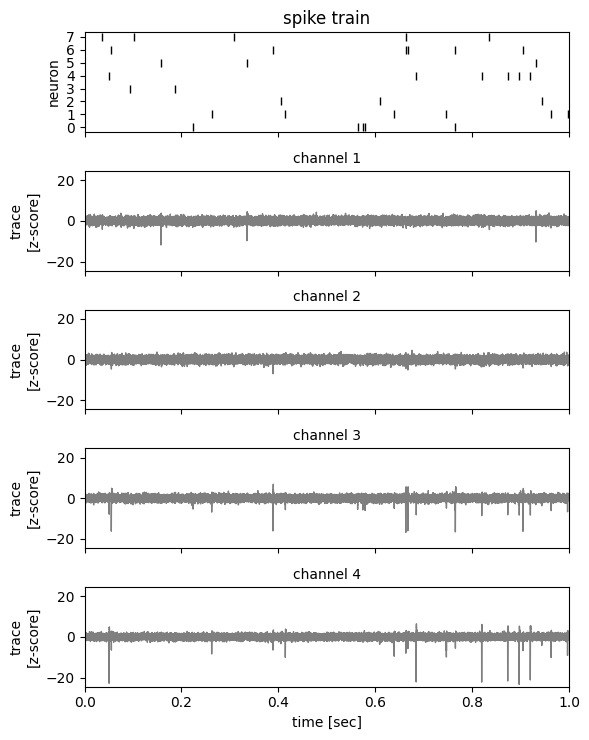

In [5]:
def plot_slice(traces: Float[Tensor, "num_samples num_channels"],
               spike_times: Int[Tensor, "num_spikes"],
               spike_ids: Int[Tensor, "num_spikes"],
               start_time: float=0,
               end_time: float=1.0,
               ylim: float=None):
    """
    Plot a slice of the recording and the corresponding spike times.

    Parameters
    ----------
    traces : torch.Tensor
        The voltage traces.
    spike_times : torch.Tensor
        The spike times, in samples.
    spike_ids : torch.Tensor
        The spike IDs, taking values 0,1,2,...,num_neurons-1
    start_time : float
        The start time of the slice, in seconds.
    end_time : float
        The end time of the slice, in seconds.
    ylim : float
        The y-limit for the traces. If None, it is set to 1.05 times the max absolute value of the traces.
    """
    # Extract constants
    num_samples, num_channels = traces.shape
    num_neurons = spike_ids.max() + 1

    # Extract the slice of the recording
    slc = slice(int(start_time * SAMPLING_FREQUENCY), int(end_time * SAMPLING_FREQUENCY))
    
    # Get the y-limit for traces if not specified
    if ylim is None:
        ylim = 1.05 * traces[slc].abs().max()

    # Make an array of times in seconds
    times_sec = torch.arange(0, num_samples) / SAMPLING_FREQUENCY
    spike_times_sec = times_sec[spike_times]
    spike_in_slice = (spike_times_sec >= start_time) & (spike_times_sec <= end_time)

    # Plot the spike raster
    fig, axs = plt.subplots(num_channels + 1, 1, sharex=True, figsize=(6, 1.5 * (num_channels + 1)))
    axs[0].plot(spike_times_sec[spike_in_slice], spike_ids[spike_in_slice], '|k', markersize=6)
    axs[0].set_ylabel("neuron")
    axs[0].set_yticks(torch.arange(0, num_neurons))
    axs[0].set_title("spike train")

    # Plot the voltage traces 
    for i in range(num_channels):
        axs[i+1].plot(times_sec[slc], traces[slc, i], color='k', lw=1, alpha=0.5)
        axs[i+1].set_title(f"channel {i+1}", fontsize=10)
        axs[i+1].set_ylim(-ylim, ylim)
        axs[i+1].set_ylabel("trace\n[z-score]")
        axs[i+1].set_xlim(start_time, end_time)
        if i == num_channels - 1: 
            axs[i+1].set_xlabel(f"time [sec]")
    
    plt.tight_layout()
    return fig, axs

def plot_waveforms(waveforms: Float[Tensor, "num_waveforms windows_size num_channels"],
                   name: str="waveform"):
    """
    Plot a grid of spike waveforms or templates.

    Parameters
    ----------
    waveforms : torch.Tensor
        The waveforms (or templates) to plot.

    name : str
        The name of the waveforms (or templates) to plot. Default is "waveform".
    """
    num_waveforms, window_size, num_channels = waveforms.shape
    times = torch.arange(-window_size//2, window_size//2) / SAMPLING_FREQUENCY * 1000
    fig, axs = plt.subplots(num_channels, num_waveforms, 
                            figsize=(1.25 * num_waveforms, 1.25 * num_channels), 
                            sharex=True, sharey=True)
    lim = 1.05 * waveforms.abs().max()
    for j in range(num_waveforms):
        for i in range(num_channels):
            axs[i,j].plot(times, waveforms[j,:,i], color='k', lw=1, alpha=0.5)
            axs[i,j].set_ylim(-lim, lim)
            # axs[i,j].set_xlabel("time [samples]")
            # axs[i,j].set_title(f"waveform {j}\n channel {i}")
            if j == 0:
                axs[i,j].set_ylabel(f"channel {i}\n [z-score]")
            if i == 0:
                axs[i,j].set_title(f"{name} {j}")
            if i == num_channels - 1:
                axs[i,j].set_xlabel(f"time [ms]")
    plt.tight_layout()
    
    return fig, axs

_ = plot_slice(
    traces,
    true_spike_times,
    true_spike_ids,
    start_time=0.0,
    end_time=1.0,
)

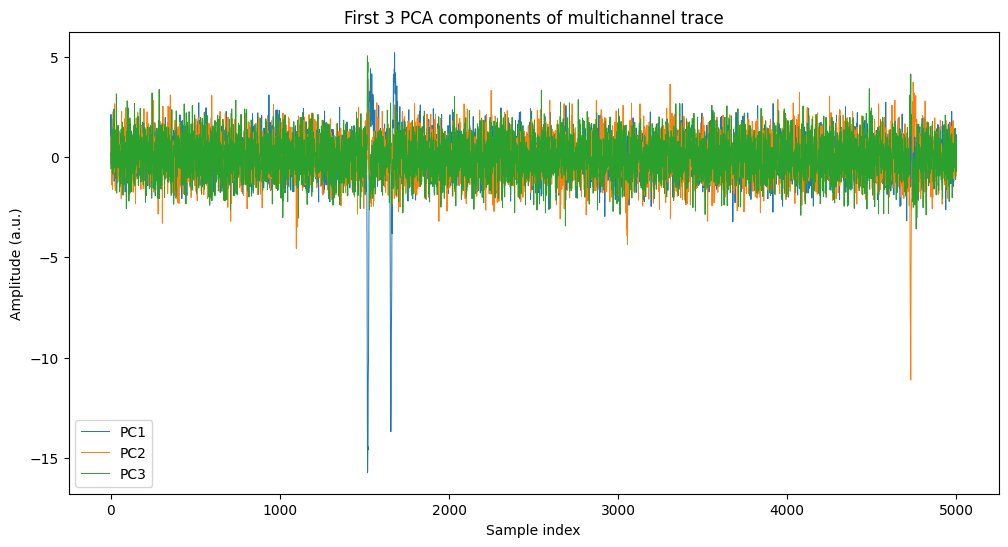

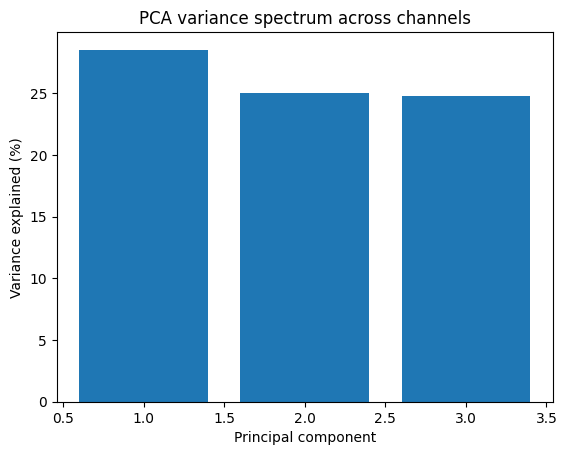

In [12]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Flatten across time for PCA across channels
X = traces.numpy()  # shape: (num_samples, num_channels)

# Standardize roughly (zero-mean per channel)
X_centered = X - X.mean(axis=0, keepdims=True)

# Fit PCA on channels
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_centered)

# Plot first few PCs as time series
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(X_pca[:5000, i], label=f"PC{i+1}", lw=0.7)
plt.legend()
plt.title("First 3 PCA components of multichannel trace")
plt.xlabel("Sample index")
plt.ylabel("Amplitude (a.u.)")
plt.show()

# Optional: explained variance
plt.bar(range(1, 4), pca.explained_variance_ratio_ * 100)
plt.xlabel("Principal component")
plt.ylabel("Variance explained (%)")
plt.title("PCA variance spectrum across channels")
plt.show()


In [6]:
traces.shape

torch.Size([3600000, 4])

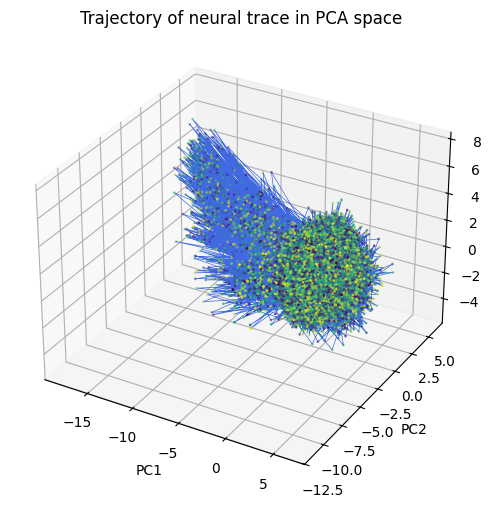

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # activates 3D projection
import numpy as np

# Project data to first 3 PCs
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_centered)

# Downsample to plot fewer points for clarity
stride = 10  # increase if it’s too dense
X3 = X_pca[::stride]
t3 = np.arange(X3.shape[0]) / SAMPLING_FREQUENCY * stride  # time in seconds

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(X3[:, 0], X3[:, 1], X3[:, 2], lw=0.5, color="royalblue")
ax.set_title("Trajectory of neural trace in PCA space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")

# optional color by time
c = plt.cm.viridis((t3 - t3.min()) / (t3.max() - t3.min()))
ax.scatter(X3[:, 0], X3[:, 1], X3[:, 2], c=c, s=1)
plt.show()




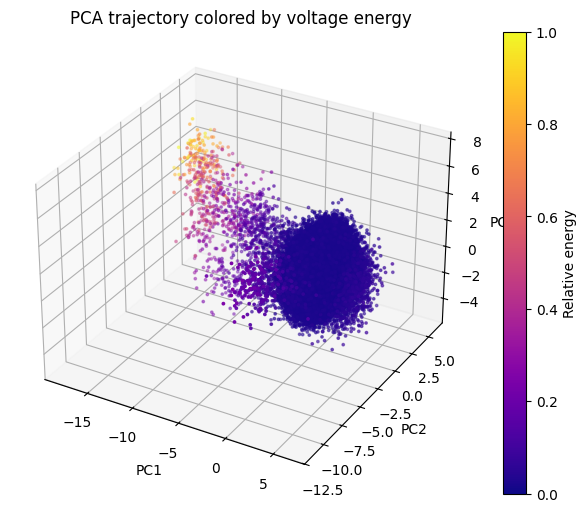

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Color by total voltage energy (sum of squares across channels)
energy = np.sum(X_centered[::stride] ** 2, axis=1)
energy = (energy - energy.min()) / (energy.max() - energy.min())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
p = ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=energy, cmap="plasma", s=3
)
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
ax.set_title("PCA trajectory colored by voltage energy")
fig.colorbar(p, ax=ax, label="Relative energy")
plt.show()


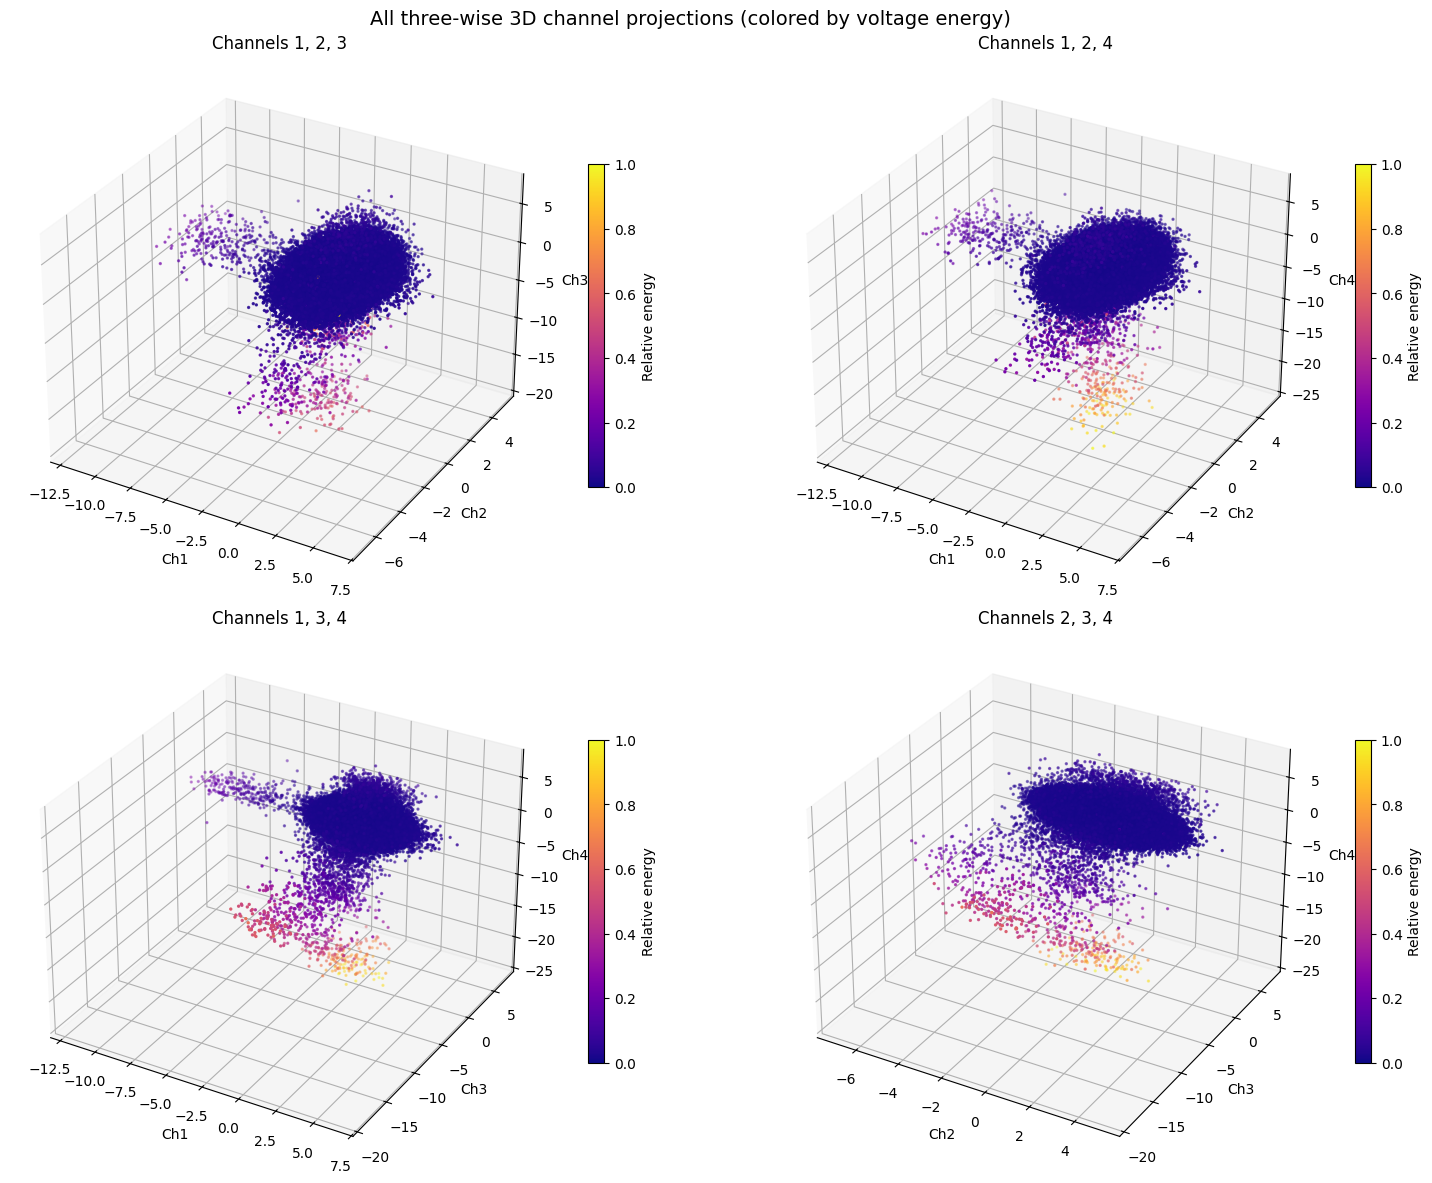

In [49]:
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D projections of raw 4-channel data
combos = list(itertools.combinations(range(4), 3))
stride = 10  # downsample for clarity
X_sampled = X_centered[::stride]

# color points by total voltage energy
energy = np.sum(X_sampled**2, axis=1)
energy = (energy - energy.min()) / (energy.max() - energy.min())

fig = plt.figure(figsize=(16, 12))

for i, (a, b, c) in enumerate(combos, 1):
    ax = fig.add_subplot(2, 2, i, projection="3d")
    p = ax.scatter(
        X_sampled[:, a],
        X_sampled[:, b],
        X_sampled[:, c],
        c=energy,
        cmap="plasma",
        s=2
    )
    ax.set_xlabel(f"Ch{a+1}")
    ax.set_ylabel(f"Ch{b+1}")
    ax.set_zlabel(f"Ch{c+1}")
    ax.set_title(f"Channels {a+1}, {b+1}, {c+1}")
    fig.colorbar(p, ax=ax, shrink=0.6, label="Relative energy")

plt.suptitle("All three-wise 3D channel projections (colored by voltage energy)", fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
traces

tensor([[ 0.8770,  0.5215, -0.1815,  0.0071],
        [ 0.1546,  0.6982,  2.0720,  0.7538],
        [-0.1168, -0.4079,  1.3060,  0.5789],
        ...,
        [ 0.7008, -0.1540, -0.8441, -0.5124],
        [ 0.9802, -3.0643,  0.6528, -0.7923],
        [ 0.2438, -0.9812, -0.7622, -0.8182]])

In [23]:
traces.mean(axis=0)

tensor([-8.7092e-09, -1.3570e-07,  2.6008e-07,  7.7341e-08])

In [ ]:
min_trace=torch.min(traces,axis=1)
min_trace_negated=-min_trace.values
peaks=signal.find_peaks(min_trace_negated)
sd4=min_trace_negated[peaks][min_trace_negated<-4.0]

(array([      2,       4,       7, ..., 3599994, 3599996, 3599998],
       shape=(1195605,)),
 {})

In [38]:
import torch
import numpy as np
from scipy import signal

# Choose a single representative channel (e.g., channel 0)
#channel_idx = 0
#trace = traces[:, channel_idx].numpy()

# Invert so spikes (negative deflections) become positive peaks
inverted = - min_trace.values

# Find all candidate peaks
peaks, properties = signal.find_peaks(inverted.numpy(), height=4.0)  # threshold ~4 µV
print(f"Initial detected peaks: {len(peaks)}")

# Enforce 3 ms (90 samples) refractory period
MIN_DISTANCE = int(0.003 * SAMPLING_FREQUENCY)
filtered_peaks = [peaks[0]]
for p in peaks[1:]:
    if p - filtered_peaks[-1] > MIN_DISTANCE:
        filtered_peaks.append(p)
filtered_peaks = np.array(filtered_peaks)
print(f"Filtered peaks (after 3 ms exclusion): {len(filtered_peaks)}")

detected_spike_times = torch.tensor(filtered_peaks)
num_detected_spikes = detected_spike_times.shape[0]


Initial detected peaks: 3699
Filtered peaks (after 3 ms exclusion): 2134


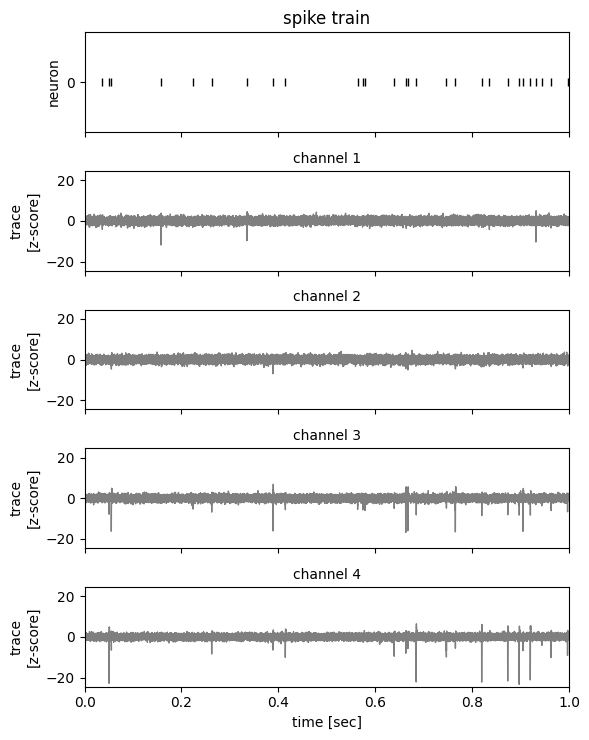

In [39]:
# Plot the inferred spike times with dummy spike ids
dummy_spike_ids = torch.zeros_like(detected_spike_times)

_ = plot_slice(
    traces,
    detected_spike_times,
    dummy_spike_ids,
    start_time=0.,
    end_time=1.0,
)

In [36]:
filtered_peaks

array([   1097,    1518,    1654, ..., 3598327, 3598763, 3599394],
      shape=(2134,))

In [32]:
SAMPLING_FREQUENCY

30000

In [44]:
def evaluate_detected_spikes(
        detected_spike_times: Int[Tensor, "num_detected_spikes"],
        true_spike_times: Int[Tensor, "num_true_spikes"]) -> dict:
    """
    This code uses a supervised baseline to evaluate how many of 
    the groundtruth spikes correspond to true spike times.
    This is the true positive rate (tp). The code also evaluates the
    true negative, false positive and false negative rates and
    returns them. 
    """
    #Compute which indices in the ground truth spikes correespond to ground truth spikes
    #Take into account that each spike creates a window around it which
    #is allocated to that spike for waveform computation
    true_spike_mask = torch.zeros(NUM_SAMPLES // WINDOW_SIZE, dtype=torch.bool)
    true_spike_mask[true_spike_times // WINDOW_SIZE] = True
    
    # Compute which indices in the detected spike times 
    detected_spike_mask = torch.zeros(NUM_SAMPLES // WINDOW_SIZE, dtype=torch.bool)
    detected_spike_mask[detected_spike_times // WINDOW_SIZE] = True
    
    # Calculate true positive, false positive, false negative and true negative erates
    tp = (true_spike_mask & detected_spike_mask).sum().item()
    fp = (detected_spike_mask & ~true_spike_mask).sum().item()
    fn = (~detected_spike_mask & true_spike_mask).sum().item()
    tn = (~detected_spike_mask & ~true_spike_mask).sum().item()

    #Return true positives (tp), false positives (fp), false negatives (fn) and true
    #negatives 
    return dict(tp=tp, fp=fp, fn=fn, tn=tn)
    
perf_stats = evaluate_detected_spikes(
    detected_spike_times,
    true_spike_times
)

recall=perf_stats['tp']/(perf_stats['tp']+perf_stats['fn'])
print('Recall: ', recall)
precision=perf_stats['tp']/(perf_stats['tp']+perf_stats['fp'])
print('Precision: ', precision)

Recall:  0.7304964539007093
Precision:  0.9235488437942425


Text(0.5, 1.05, 'First 5 spike waveforms')

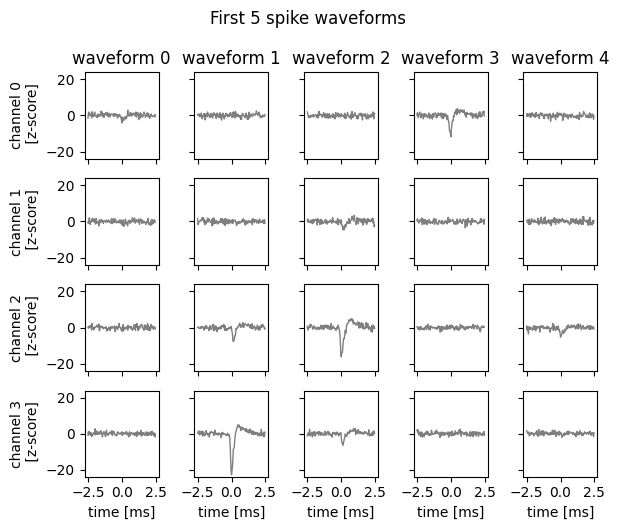

In [46]:
spike_waveforms = torch.zeros((num_detected_spikes, WINDOW_SIZE, NUM_CHANNELS))

for i, t in enumerate(detected_spike_times):
    slc = slice(t - WINDOW_SIZE // 2, t + WINDOW_SIZE // 2)
    spike_waveforms[i] = traces[slc]

# Plot a few of the waveforms
fig, axs = plot_waveforms(spike_waveforms[:5], name="waveform")
fig.suptitle("First 5 spike waveforms", y=1.05)

In [51]:
spike_waveforms.shape

torch.Size([2134, 150, 4])

Explained variance ratio: [0.3168126 0.1679378]


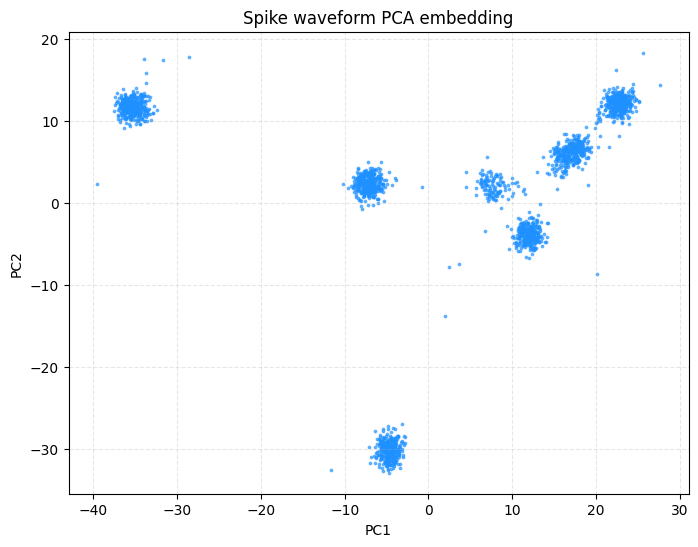

In [53]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# assume spike_waveforms: [num_spikes, window, channels]
num_spikes, window, num_channels = spike_waveforms.shape

# flatten each waveform across time × channels
X = spike_waveforms.reshape(num_spikes, -1).cpu().numpy()

# center and apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=3, alpha=0.6, c="dodgerblue")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Spike waveform PCA embedding")
plt.grid(True, ls="--", alpha=0.3)
plt.show()


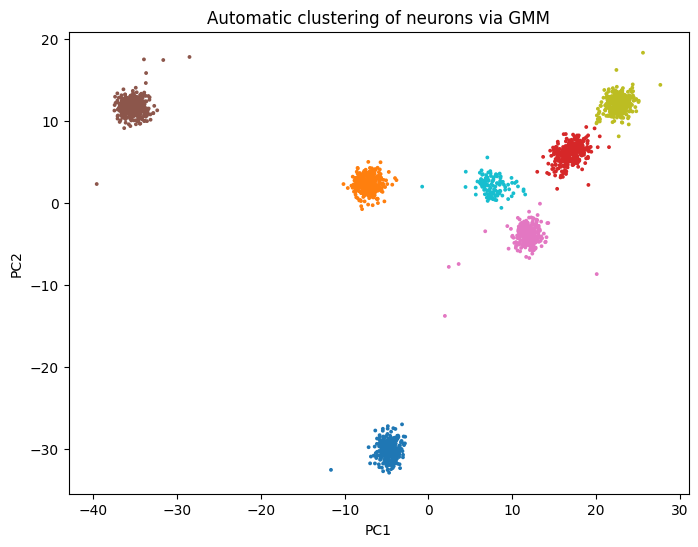

Number of active clusters: 7


In [55]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=7, covariance_type="full", random_state=0)
gmm.fit(X_pca)

labels = gmm.predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=3, cmap="tab10")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.title("Automatic clustering of neurons via GMM")
plt.show()

print(f"Number of active clusters: {len(np.unique(labels))}")


In [56]:
from sklearn.mixture import BayesianGaussianMixture

bgmm = BayesianGaussianMixture(
    n_components=15,
    weight_concentration_prior_type="dirichlet_process",
    random_state=0
).fit(X_pca)

print(f"Effective number of neurons: {(bgmm.weights_ > 0.01).sum()}")


Effective number of neurons: 7


In [ ]:
from torch.distributions.normal import Normal

class SimpleSpikeSorter:
    """
    A simple spike sorter that uses a Gaussian mixture model (GMM) to fit the templates.
    The GMM is fit to the putative spike waveforms using coordinate ascent on the 
    log joint probability of the model.

    Parameters
    ----------
    initial_templates : torch.Tensor
        The initial templates for the GMM, with shape (num_neurons, window_size, num_channels).

    noise_scale : float
        The scale of the noise in the GMM. This is used to compute the log likelihood of
        the spike waveforms given the templates. The noise scale is assumed to be the same
        for all neurons, samples, and channels. Note that the scale is the standard deviation
        of the noise, not the variance.
    """
    templates: Float[Tensor, "num_neurons window_size num_channels"]
    noise_scale: float

    def __init__(
            self,
            initial_templates: Float[Tensor, "num_neurons window_size num_channels"],
            noise_scale: float = 1.0,
            ) -> None:
        self.templates = initial_templates
        self.noise_scale = noise_scale

    @property
    def num_neurons(self) -> int:
        return self.templates.shape[0]
    
    def log_probability(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            spike_ids: Int[Tensor, "num_spikes"]) -> float:
        """
        Compute the log probability of the spike waveforms given the templates
        using torch.distributions.Normal.
        """
        unique_ids=torch.unique(spike_ids)
        cluster_log_prob=[]
        num_spikes, window_size, num_channels=spike_waveforms.shape
        for k in list(unique_ids.numpy()):
            means=self.templates[k].flatten()
            normal = Normal(means, self.noise_scale*torch.ones_like(means))
            cluster_ll=normal.log_prob(spike_waveforms[spike_ids==k]).reshape(-1,window_size*num_channels)
            cluster_log_prob.append(cluster_ll.sum().item())
        ll=sum(cluster_log_prob)
        return ll

    def update_templates(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            spike_ids: Int[Tensor, "num_spikes"]):
        """
        Update the templates using the spike waveforms and spike IDs.
        """
        # TODO

    def update_spike_ids(
            self,
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            ) -> Int[Tensor, "num_spikes"]:
        """
        Update the spike IDs using the templates and spike waveforms.
        Use torch.distributions.Normal to evaluate the log probabilites.
        """
        # TODO

        return spike_ids
    
    def fit(self, 
            spike_waveforms: Float[Tensor, "num_spikes window_size num_channels"],
            num_iterations: int=10,
            ) -> tuple[Float[Tensor, "num_iterations"], Int[Tensor, "num_spikes"]]:
        """
        Fit the GMM to the spike waveforms using coordinate ascent on the log joint probability.
        """
        # Initialize the spike IDs
        spike_ids = self.update_spike_ids(spike_waveforms)

        # Iterate to update the templates and spike IDs
        lps = []
        for itr in range(num_iterations):
            lps.append(self.log_probability(spike_waveforms, spike_ids))
            print(f"iteration {itr}: log probability = {lps[-1]:.2f}")

            # Update the templates and spike IDs
            self.update_templates(spike_waveforms, spike_ids)
            spike_ids = self.update_spike_ids(spike_waveforms)

        # Return the final spike IDs
        return torch.tensor(lps), spike_ids

In [58]:
# import the torch module
import torch

# create the mean with 5 values
mean = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# create the standard deviation with 5 values
std = torch.tensor([1.22, 0.78, 0.56, 1.23, 0.23])

# create normal distribution
print(torch.normal(mean, std))

from torch.distributions import Normal

dist = Normal(mean, std)
print(dist)         # prints a distribution object
print(dist.sample())  # now you can explicitly sample from it


tensor([3.9841, 3.5632, 4.4975, 3.9516, 5.3592])
Normal(loc: torch.Size([5]), scale: torch.Size([5]))
tensor([1.0152, 0.4969, 2.4032, 4.6505, 5.1079])
